# Business Analytics Project

## Table of Content
1. [Data Preparation](#1.-Data-Preparation)
2. [Data Visualization](#2.-Data-Visualization)
3. [Data Modelling](#3.-Data-Modelling)

### 1. Data Preparation

Data is downloaded and placed in the same folder with this notebook. Then, the top 5 row of the dataframe is printed.

In [1]:
from jupyterthemes import jtplot
jtplot.style(theme='onedork')
jtplot.style(context='talk', fscale=1.4, spines=True, gridlines='--')
jtplot.style(ticks=True, grid=True, figsize=(10, 6))

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
df = pd.read_csv('data_retail.csv', sep=';')
df.head()

,no,Row_Num,Customer_ID,Product,First_Transaction,Last_Transaction,Average_Transaction_Amount,Count_Transaction
0,1,1,29531,Jacket,1466304274396,1538718482608,1467681,22
1,2,2,29531,Shoes,1406077331494,1545735761270,1269337,41
2,3,3,141526,Bag,1493349147000,1548322802000,310915,30
3,4,4,141526,Jacket,1493362372547,1547643603911,722632,27
4,5,5,37545,Shoes,1429178498531,1542891221530,1775036,25


Or to print a random data, use `.sample()`

In [3]:
df.sample(5)

,no,Row_Num,Customer_ID,Product,First_Transaction,Last_Transaction,Average_Transaction_Amount,Count_Transaction
78484,78485,78485,479889,Shoes,1527160173437,1528462281428,975434,2
64713,64714,64714,390348,Jacket,1534866681949,1534866745406,154594,2
85027,85028,85028,543767,Shoes,1530325317909,1530325317909,441200,1
11668,11669,11669,174006,Shoes,1511274187123,1541497522183,703700,26
20520,20521,20521,64036,Jacket,1453428032592,1472637137715,465324,5


We do not need the first two columns as it does not give any values to our data, so we neglect them.

In [4]:
df = df[df.columns[2:]]
df.head()

,Customer_ID,Product,First_Transaction,Last_Transaction,Average_Transaction_Amount,Count_Transaction
0,29531,Jacket,1466304274396,1538718482608,1467681,22
1,29531,Shoes,1406077331494,1545735761270,1269337,41
2,141526,Bag,1493349147000,1548322802000,310915,30
3,141526,Jacket,1493362372547,1547643603911,722632,27
4,37545,Shoes,1429178498531,1542891221530,1775036,25


We use `info()` command to get a clear look of the dataframe. From this, we can see the total number of rows the dataframe has and any null columns can be easily identified. We can see the data type of each columns as well.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   Customer_ID                 100000 non-null  int64 
 1   Product                     100000 non-null  object
 2   First_Transaction           100000 non-null  int64 
 3   Last_Transaction            100000 non-null  int64 
 4   Average_Transaction_Amount  100000 non-null  int64 
 5   Count_Transaction           100000 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 4.6+ MB


Notice that the `First_Transaction` and the `Last_Transaction` has `int64` as their data type. We should change it to a `datetime` type to reflect the true meaning of its values.

In [6]:
df[['First_Transaction','Last_Transaction']].head()

,First_Transaction,Last_Transaction
0,1466304274396,1538718482608
1,1406077331494,1545735761270
2,1493349147000,1548322802000
3,1493362372547,1547643603911
4,1429178498531,1542891221530


In [7]:
df['First_Transaction'] = pd.to_datetime(df['First_Transaction']/1000, unit='s', origin='unix')
df['Last_Transaction'] = pd.to_datetime(df['Last_Transaction']/1000, unit='s', origin='unix')
df[['First_Transaction','Last_Transaction']].head()

,First_Transaction,Last_Transaction
0,2016-06-19 02:44:34.395999908,2018-10-05 05:48:02.608000040
1,2014-07-23 01:02:11.493999958,2018-12-25 11:02:41.269999981
2,2017-04-28 03:12:27.000000000,2019-01-24 09:40:02.000000000
3,2017-04-28 06:52:52.546999931,2019-01-16 13:00:03.911000013
4,2015-04-16 10:01:38.530999899,2018-11-22 12:53:41.529999970


The results obtained are as follows:

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Customer_ID                 100000 non-null  int64         
 1   Product                     100000 non-null  object        
 2   First_Transaction           100000 non-null  datetime64[ns]
 3   Last_Transaction            100000 non-null  datetime64[ns]
 4   Average_Transaction_Amount  100000 non-null  int64         
 5   Count_Transaction           100000 non-null  int64         
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 4.6+ MB


We can see that the datatype in both columns `First_Transaction` and `Last_Transaction` has been converted to datetime.

We then create a new column to determine which customers had made recent purchase and which are not. This column is created with predetermined conditions, that is, if the customer had a `Last_Transaction` before the last 6 months of the data update, then they are considered **churn**. Meanwhile, if there is `Last_Transsaction` occurs after the last 6 months of the update, then it is considered **not churn**.

Before creating the column, we need to know when the last data update was done by checking the last data from `Last_Transaction`. This churn column will be created with datatype *int* so that there will only be two types of data, labeled `1` for the churn customer and `0` otherwise.

In [9]:
# check the last transaction
max(df['Last_Transaction'])

Timestamp('2019-02-01 23:57:57.286000013')

With simple math, we subtract 6 months from the last date of `Last_Transaction` and we get `2018-08-01`.

In [10]:
# classify the status of the customer with boolean type
df.loc[df['Last_Transaction'] <= '2018-08-01', 'is_churn'] = 1
df.loc[df['Last_Transaction'] >= '2018-08-01', 'is_churn'] = 0
df['is_churn'] = df['is_churn'].astype('int64')
df[['Customer_ID', 'Last_Transaction', 'is_churn']].sample(5)

,Customer_ID,Last_Transaction,is_churn
40383,57893,2015-11-15 17:48:26.645999908,1
11654,26228,2017-11-15 07:07:30.589999914,1
51536,217022,2017-12-10 18:46:12.489000082,1
30582,32097,2017-09-02 09:50:09.319000006,1
17816,33036,2018-10-08 11:18:59.124000072,0


We can see the last column named `is_churn` contains the information of the customer status as we needed.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Customer_ID                 100000 non-null  int64         
 1   Product                     100000 non-null  object        
 2   First_Transaction           100000 non-null  datetime64[ns]
 3   Last_Transaction            100000 non-null  datetime64[ns]
 4   Average_Transaction_Amount  100000 non-null  int64         
 5   Count_Transaction           100000 non-null  int64         
 6   is_churn                    100000 non-null  int64         
dtypes: datetime64[ns](2), int64(4), object(1)
memory usage: 5.3+ MB


### 2. Data Visualization

The first thing that we want to visualize is the trend of customer purchase with respect to year using bar chart. Thus, we need a new column that only display the year of `First_Transaction` and `Last_Transaction` and write it into `Year_First_Transaction` and `Year_Last_Transaction` respectively.

In [12]:
df['Year_First_Transaction'] = df['First_Transaction'].dt.year
df['Year_Last_Transaction'] = df['Last_Transaction'].dt.year
df[['Customer_ID', 'Year_First_Transaction', 'Year_Last_Transaction']].head()

,Customer_ID,Year_First_Transaction,Year_Last_Transaction
0,29531,2016,2018
1,29531,2014,2018
2,141526,2017,2019
3,141526,2017,2019
4,37545,2015,2018


We grouped the data by `Year_First_Transaction` column with count in the `Customer_ID` column to get the number of customer that have made the first transaction in each year from 2013 to 2019.

In [13]:
df_year = df.groupby(['Year_First_Transaction'])['Customer_ID'].count()
df_year

Year_First_Transaction
2013     1007
2014     4954
2015    11235
2016    17656
2017    31828
2018    30327
2019     2993
Name: Customer_ID, dtype: int64

Then we can proceed with the bar graph.

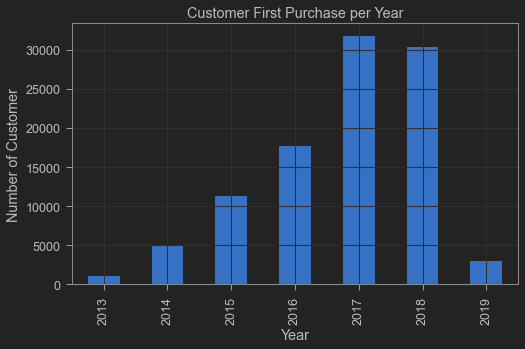

In [14]:
import matplotlib.pyplot as plt
df_year.plot(x='Year_First_Transaction', y='Customer_ID', kind='bar',
             title='Customer First Purchase per Year')
plt.xlabel('Year')
plt.ylabel('Number of Customer')
plt.show()

#### Observation
From the bar chart above, we can see most customer made their first purchase in 2017 and 2018. This shows that the business has a fairy good growth as it continues to record their new customers from 2013 to 2017. Then, a drastic decline in the new customers occured in 2018 to 2019.

Now, we create another bar chart for the number of transactions for each year from 2013 to 2019. For this, we need to get the total transaction for each year and group the `Year_First_Transaction` column with the total of `Count_Transaction` column.

In [15]:
df_count = df.groupby(['Year_First_Transaction'])['Count_Transaction'].sum()
df_count

Year_First_Transaction
2013     23154
2014    165494
2015    297445
2016    278707
2017    299199
2018     99989
2019      5862
Name: Count_Transaction, dtype: int64

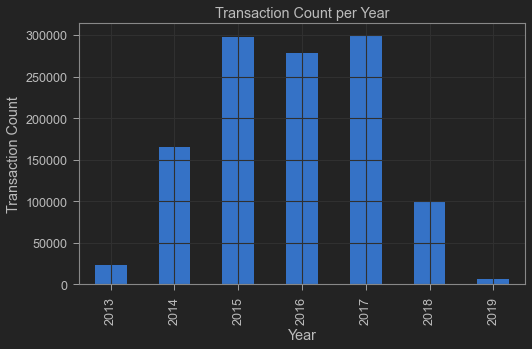

In [16]:
# plt.clf() # clear previous graph
df_count.plot(x='Year_First_Transaction', y='Count_Transaction', kind='bar',
              title='Transaction Count per Year')
plt.xlabel('Year')
plt.ylabel('Transaction Count')
plt.show()

#### Observation
From the chart above, we can say that the sales increases from 2013 to 2015 and there is a slight decline in 2016. The sales continue to rise again until 2017 and had a drastic decline in the next two years.

Next, we can visualize the average number of transaction per year for each product sold in the store. To do this, we create a new variable to store the mean of product sold and group it by `Year_First_Transaction` column.

In [17]:
product_sold = df.groupby(['Product', 'Year_First_Transaction']).mean().reset_index()
product_sold[['Product', 'Year_First_Transaction', 'Average_Transaction_Amount']]

,Product,Year_First_Transaction,Average_Transaction_Amount
0,Bag,2017,1.109583e+06
1,Bag,2018,1.337614e+06
2,Bag,2019,1.287529e+06
3,Jacket,2014,1.467937e+06
4,Jacket,2015,1.296265e+06
5,Jacket,2016,1.317344e+06
6,Jacket,2017,1.369034e+06
7,Jacket,2018,1.419074e+06
8,Jacket,2019,1.447536e+06
9,Jersey,2017,1.490890e+06


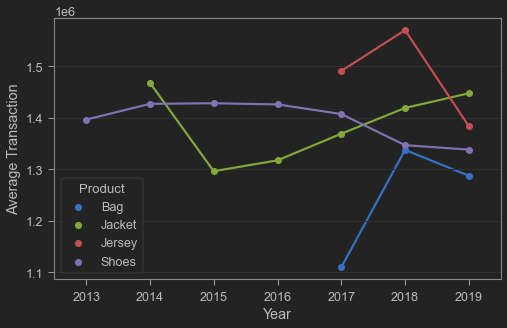

In [18]:
import seaborn as sns
# plt.clf()
sns.pointplot(x = 'Year_First_Transaction', y = 'Average_Transaction_Amount',
              data = product_sold, hue = 'Product')
#sns.set(rc={'figure.figsize':(12,10)})
plt.xlabel('Year')
plt.ylabel('Average Transaction')
plt.show()

#### Observation
Line charts are used to get more detailed results and to compare the sales of each product. As we can see, throughout the year 2013 to 2019, *Shoes* have the most stable average sales than the other three products. Unlike the *Jacket* product which had a high average sales in 2014, but fell drastically in 2015 and started to rise again in 2016 to 2019. For *Jersey* product, sales were quite good in 2017 to 2018 but recorded a significant decrease in 2019. Meanwhile the *Bag* product had a quite impressive increase in sales from 2017 to 2018, but decreased slightly in 2019.

#### Recommendation
In 2019, *Jacket* becomes the promising product to sell because it is experiencing an increase in sales. Other products could be sold in bundles, for example shoes and bag at the start of the new school year. Making advertisements for the less popular products could also increase the average sales of these products.

For the next part, we want to know whether customer came back to buy the same product. This time, we will be using pie chart. First, using the values from `Customer_ID`, we have to pivot the data and display the `Product` column with the respective churn status.

In [19]:
df_pivot = df.pivot_table(index = 'is_churn', columns = 'Product', values = 'Customer_ID',
                          aggfunc = 'count', fill_value = 0)
df_pivot

Product,Bag,Jacket,Jersey,Shoes
is_churn,,,,
0,4976,11123,1268,16064
1,7508,23827,2144,33090


After pivoting is done, the calculation is carried out with an ascending order in order to obtain the amount of churn for each product.

In [20]:
plot_product = df_pivot.count().sort_values(ascending = False).head(5).index
plot_product

Index(['Shoes', 'Jersey', 'Jacket', 'Bag'], dtype='object', name='Product')

In [21]:
df_pivot = df_pivot.reindex(columns = plot_product)
df_pivot

Product,Shoes,Jersey,Jacket,Bag
is_churn,,,,
0,16064,1268,11123,4976
1,33090,2144,23827,7508


Finally, visualization is done by using a pie chart. Here are the results of the diagram formed.

In [22]:
df_pivot.loc[0].values

array([16064,  1268, 11123,  4976], dtype=int64)

In [23]:
df_pivot.keys()

Index(['Shoes', 'Jersey', 'Jacket', 'Bag'], dtype='object', name='Product')

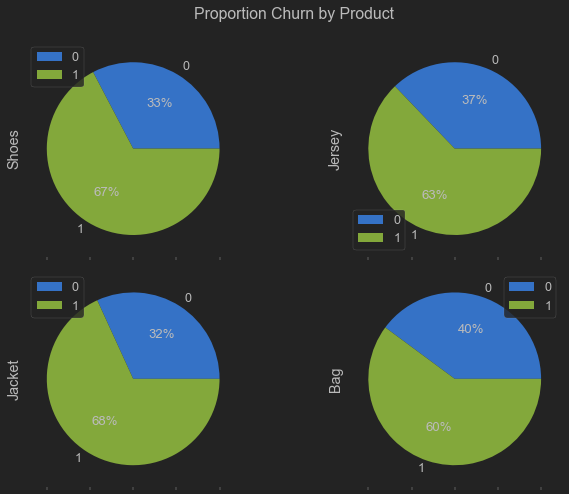

In [24]:
# plt.clf()
df_pivot.plot.pie(subplots = True, figsize = (10,7), layout = (-1, 2),
                  autopct = "%1.0f%%", title = 'Proportion Churn by Product')
plt.tight_layout()
plt.show()

#### Observation
For all of the four product sold, about 60% of customers will return to buy the product after the first purchase. So we can said that each product has its respective fans by repurchasing the same product. From the four product, we can see that *Jacket* has the least amount of churn customers while *Bag* product has the most churning customers.

Finally, we can visualize the number of transactions carried out by the same person and the average number of transaction carried out. This analysis can be performed using bar chart.

Before we create the diagram, we need to make a categorization of the number of transaction and later we will also make a categorization based on the average transaction value. This categorization is created by defining a new function. The following table is the desired categorization.

| Category | Total Amount of Transaction | Mathematical Terms |
| --- | --- | --- |
| A | 1 | $$x=1$$ |
| B | 2 to 3 | $$2 \leq x \leq 3$$ |
| C | 4 to 6 | $$4 \leq x \leq 6$$ |
| D | 7 to 10 | $$7 \leq x \leq 10$$ |
| E | more than 10 | $$x > 10$$ |

The category is formed by defining a new function that will create five categories, each with their own total amount of transaction. `Row` is used as the input parameter because this categorization is based on the `Count_Transaction` row, where if the customer made only one purchase, then it is categorized as `A`, if it is more than one but less than 3, it is included in category `B` and so on as in the table above.

In [25]:
def category1(row):
    if (row['Count_Transaction'] == 1):
        cat = '(A) 1'
    elif (row['Count_Transaction'] >= 2 and row['Count_Transaction'] <= 3):
        cat = '(B) 2 to 3'
    elif (row['Count_Transaction'] >= 4 and row['Count_Transaction'] <= 6):
        cat = '(C) 4 to 6'
    elif (row['Count_Transaction'] >= 7 and row['Count_Transaction'] <= 10):
        cat = '(D) 7 to 10'
    else:
        cat = '(E) > 10'
    return cat

In [26]:
# add a new column
df['Count_Transaction_Group'] = df.apply(category1, axis=1)
df[['Customer_ID', 'Count_Transaction', 'Count_Transaction_Group']].head()

,Customer_ID,Count_Transaction,Count_Transaction_Group
0,29531,22,(E) > 10
1,29531,41,(E) > 10
2,141526,30,(E) > 10
3,141526,27,(E) > 10
4,37545,25,(E) > 10


In [27]:
df_cat = df.groupby(['Count_Transaction_Group'])['Count_Transaction'].count()
df_cat

Count_Transaction_Group
(A) 1          49255
(B) 2 to 3     14272
(C) 4 to 6     12126
(D) 7 to 10     2890
(E) > 10       21457
Name: Count_Transaction, dtype: int64

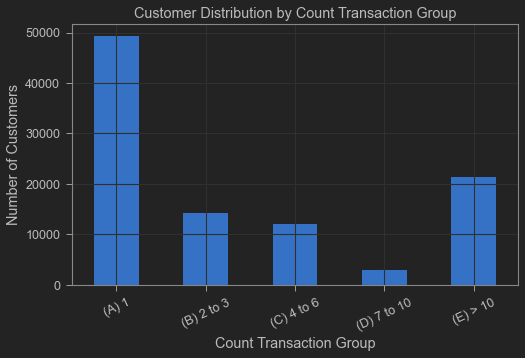

In [28]:
# plt.clf()
df_cat.plot(x = 'Count_Transaction_Group', y = 'Customer_ID', kind = 'bar', 
            title = 'Customer Distribution by Count Transaction Group')
plt.xlabel('Count Transaction Group')
plt.ylabel('Number of Customers')
plt.xticks(rotation = 25)
plt.show()

#### Observation
We can see that the majority of customers only make one transaction, but customers that made more than 10 transactions are also quite a lot. If we total up customers that made more than one transaction, the value is larger than customers who made only one purchase.

Using similar method, the visualization on the average transaction value of each customer can be done. The following table is the desired categorization.

| Category | Total Amount of Transaction | Mathematical Terms |
| --- | --- | --- |
| A | 0 to 0.5M | $$x \leq 0.5 \times 10^6$$ |
| B | 0.5M to 1.0M | $$0.5 \times 10^6 \leq x \leq 1.0 \times 10^6$$ |
| C | 1.0M to 1.5M | $$1.0 \times 10^6 \leq x \leq 1.5 \times 10^6$$ |
| D | 1.5M to 2.0M | $$1.5 \times 10^6 \leq x \leq 2.0 \times 10^6$$ |
| E | more than 2.0M | $$x > 2.0 \times 10^6$$ |

In [29]:
def category2(row):
    if (row['Average_Transaction_Amount'] <= 500000):
        cat = '(A) < 0.5M'
    elif (row['Average_Transaction_Amount'] > 500000 and row['Average_Transaction_Amount'] <= 1000000):
        cat = '(B) 0.5M - 1.0M'
    elif (row['Average_Transaction_Amount'] > 1000000 and row['Average_Transaction_Amount'] <= 1500000):
        cat = '(C) 1.0M - 1.5M'
    elif (row['Average_Transaction_Amount'] > 1500000 and row['Average_Transaction_Amount'] <= 2000000):
        cat = '(D) 1.5M - 2M'
    else:
        cat = '(E) > 2M'
    return cat

In [30]:
# add new column
df['Average_Transaction_Amount_Group'] = df.apply(category2, axis=1)
df[['Customer_ID', 'Average_Transaction_Amount', 'Average_Transaction_Amount_Group']].head()

,Customer_ID,Average_Transaction_Amount,Average_Transaction_Amount_Group
0,29531,1467681,(C) 1.0M - 1.5M
1,29531,1269337,(C) 1.0M - 1.5M
2,141526,310915,(A) < 0.5M
3,141526,722632,(B) 0.5M - 1.0M
4,37545,1775036,(D) 1.5M - 2M


In [31]:
df_avg = df.groupby(['Average_Transaction_Amount_Group'])['Customer_ID'].count()
df_avg

Average_Transaction_Amount_Group
(A) < 0.5M         26828
(B) 0.5M - 1.0M    27469
(C) 1.0M - 1.5M    17378
(D) 1.5M - 2M      10028
(E) > 2M           18297
Name: Customer_ID, dtype: int64

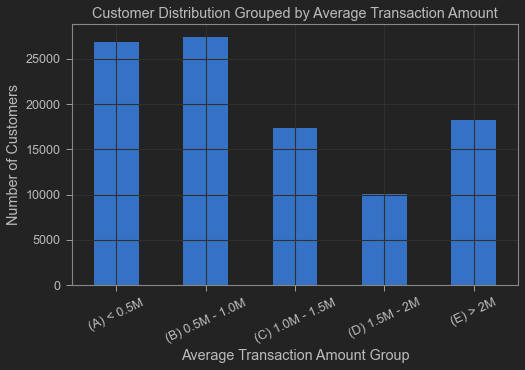

In [32]:
df_avg.plot(x = 'Average_Transaction_Amount_Group', y = 'Customer_ID', kind = 'bar',
            title = 'Customer Distribution Grouped by Average Transaction Amount')
plt.xlabel('Average Transaction Amount Group')
plt.ylabel('Number of Customers')
plt.xticks(rotation = 25)
plt.show()

#### Observation
From the bar chart above, we can see that the most of the customers spend less than 1M on average. This shows that the customers' purchasing power is good enough and there is no need to make changes to the price of the product that are being sold previously.

### 3. Data Modelling

In this section, we will try to create a simple model with the data that we have. First thing first, we need to determine the dependent and independent variable to used in our modelling. In this case, we will denote X as independent variable while dependent variable as Y. The independent variables that we choose are `Average_Transaction_Amount`, `Count_Transaction`, and `Year_Diff`.

The `Year_Diff` column is a new column which we will create by subtracting the `Year_First_Transaction` from the `Year_Last_Transaction` column. We will group those columns together under a new column called `feature_column` and label it as variable X. As for the dependent variable, y, the column that we will use is `is_churn`.

In [33]:
df['Year_Diff'] = df['Year_Last_Transaction'] - df['Year_First_Transaction']
df['Year_Diff'].head()

0    2
1    4
2    2
3    2
4    3
Name: Year_Diff, dtype: int64

In [34]:
feature_columns = ['Average_Transaction_Amount', 'Count_Transaction', 'Year_Diff']
X = df[feature_columns]
X.head()

,Average_Transaction_Amount,Count_Transaction,Year_Diff
0,1467681,22,2
1,1269337,41,4
2,310915,30,2
3,722632,27,2
4,1775036,25,3


In [35]:
y = df['is_churn']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: is_churn, dtype: int64

In [36]:
print("X.shape :", X.shape)
print("y.shape :", y.shape)

X.shape : (100000, 3)
y.shape : (100000,)


Next, we split X and y into training and testing. The testing part is 25% of our data set while the training part is 75%.

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [38]:
print("X_train.shape :", X_train.shape)
print("y_train.shape :", y_train.shape)
print("X_test.shape  :", X_test.shape)
print("y_test.shape  :", y_test.shape)

X_train.shape : (75000, 3)
y_train.shape : (75000,)
X_test.shape  : (25000, 3)
y_test.shape  : (25000,)


The next step is to create a *Logistic Regression* model and initiate the model, fit, and evaluation of the model using *confusion matrix*. 

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# initialize the model
model = LogisticRegression()

# fit the model with data
model.fit(X_train, y_train)

# predict the model
y_pred = model.predict(X_test)

In [40]:
print("y_pred.shape:", y_pred.shape)
print("y_test.shape:", y_test.shape)

y_pred.shape: (25000,)
y_test.shape: (25000,)


In [41]:
print('Accuracy: ', model.score(X_test, y_test))  

Accuracy:  0.66668


In [42]:
# model evaluation using confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix: {cnf_matrix}")

Confusion Matrix: [[    1  8330]
 [    3 16666]]


The calculated confusion matrix is visualized using a heatmap diagram from Seaborn.

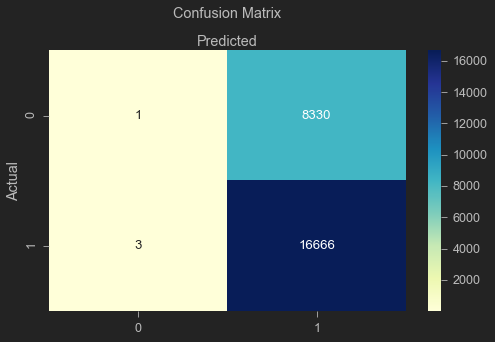

In [43]:
import numpy as np
# plt.clf()
class_name = [0, 1]
fig, ax = plt.subplots()

tick_marks = np.arange(len(class_name))
plt.xticks(tick_marks, class_name)
plt.yticks(tick_marks, class_name)

sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='YlGnBu', fmt='g')
ax.xaxis.set_label_position('top')
plt.title('Confusion Matrix', y=1.1)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Observation
From the heatmap of the confusion matrix above, we can see that the *true positive* value is `16666`, *true negative* is `1`, *false positive* is `3` and *false negative* has the value of `8330`.

We will next calculate the accuracy, precision, and recall score of this model.

In [44]:
# method 1
from sklearn.metrics import accuracy_score, precision_score, recall_score
print('Accuracy  :', accuracy_score(y_test, y_pred))
print('Precision :', precision_score(y_test, y_pred, average='micro'))
print('Recall    :', recall_score(y_test, y_pred, average='micro'))

Accuracy  : 0.66668
Precision : 0.66668
Recall    : 0.66668


In [45]:
# method 2
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.25      0.00      0.00      8331
           1       0.67      1.00      0.80     16669

    accuracy                           0.67     25000
   macro avg       0.46      0.50      0.40     25000
weighted avg       0.53      0.67      0.53     25000



#### Conclusion
The accuracy, precision and recall values for our Logistic Regression model are the same, which is `0.66668`. It can be said that the model can be used because it has fairly good level of accuracy.